In [17]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 19.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [147]:
import pandas as pd
import numpy as np
from scipy.stats import norm 
import statistics 

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

sns.set_context('poster')
sns.set(rc={'figure.figsize': (14., 8.)})
sns.set_style('whitegrid')

# Análisis
# ==============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_absolute_error

import pickle


## 1. Análisis exploratorio de los datos (EDA)

In [2]:
temperatura = pd.read_excel('../data/AEMET_temperature_data_2014-2020.xlsx', parse_dates=[0])

In [3]:
temperatura

,Unnamed: 0,T (ºC)
0,2014-01-01,11.48750
1,2014-01-02,13.08750
2,2014-01-03,14.43125
3,2014-01-04,11.98125
4,2014-01-05,10.94375
...,...,...
2552,2020-12-27,6.55625
2553,2020-12-28,8.61875
2554,2020-12-29,7.54375
2555,2020-12-30,7.00000


In [5]:
temperatura.rename(columns={'Unnamed: 0': 'date', 'T (ºC)': 'Temperature'}, inplace=True)
temperatura.set_index('date',inplace=True)
temperatura.head()

,Temperature
date,
2014-01-01,11.48750
2014-01-02,13.08750
2014-01-03,14.43125
2014-01-04,11.98125
2014-01-05,10.94375


In [7]:
temperatura.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2014-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB


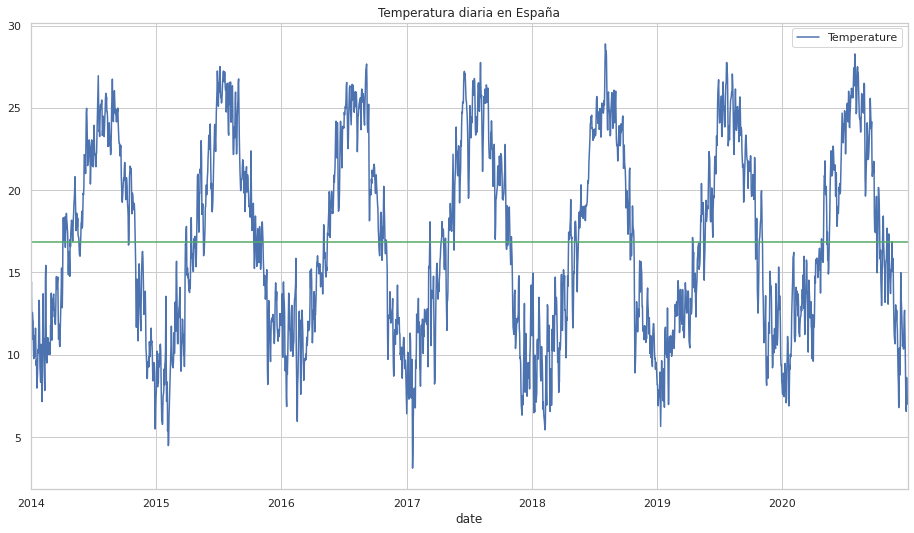

In [12]:
temperatura.plot();
plt.title("Temperatura diaria en España")
plt.axhline(temperatura.Temperature.mean(), c="g", label="media");

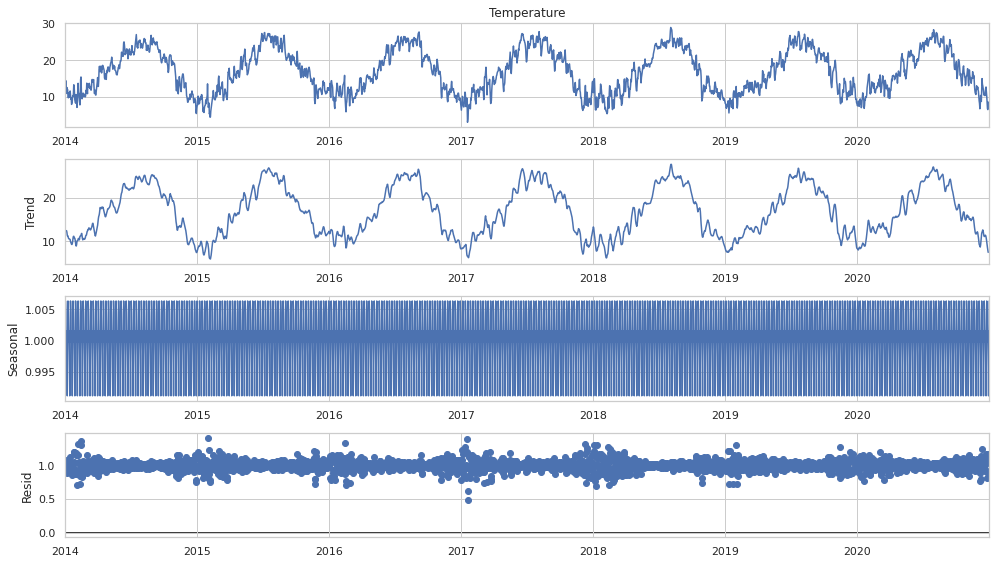

In [38]:
result = seasonal_decompose(temperatura.Temperature, 
                            model ='multiplicative')
result.plot();

Realizamos un test estadístico con adfuller para verificar que los datos de temperatura son estacionarios. Este nos dará un p-valor que si es menor que 0,05 nos permitirá rechazar la hipótesis nula de que los datos NO son estacionarios al 95%

In [15]:
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(temperatura.Temperature)

1. ADF :  -3.1119405128442215
2. P-Value :  0.025682064133844624
3. Num Of Lags :  27
4. Num Of Observations Used For ADF Regression: 2529
5. Critical Values :
	 1% :  -3.432938355012086
	 5% :  -2.8626835272597217
	 10% :  -2.567378742868999


Podemos rechazar la hipótesis nula.Los valores son estacionarios.

Por lo tanto podremos usar un modelo ARIMA (auto regresion + integración + medias moviles) para predecir la temperatura a futuro.

## 2. Definición y entrenamiento del modelo

### 2.1. ARIMA

In [20]:
stepwise_fit = auto_arima(temperatura.Temperature, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7396.377, Time=4.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16249.617, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7740.265, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13161.139, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21985.674, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7495.372, Time=1.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7510.139, Time=1.24 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=7390.147, Time=5.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7410.071, Time=4.35 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.42 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=7392.719, Time=7.88 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=7390.396, Time=5.72 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=7393.158, Time=8.14 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=7393.505, Time=8.74 sec
 ARIMA(3,0,2)(0,0,0)[0]            

In [21]:

train=temperatura.iloc[:-365]
test=temperatura.iloc[-365:]
print(train.shape,test.shape)

(2192, 1) (365, 1)


In [32]:
model=ARIMA(train['Temperature'],order=(3,0,2))
result=model.fit()
result.summary()

/home/cleonortiz/anaconda3/envs/modelo/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cleonortiz/anaconda3/envs/modelo/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cleonortiz/anaconda3/envs/modelo/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Temperature   No. Observations:                 2192
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -3159.942
Date:                Tue, 01 Mar 2022   AIC                           6333.885
Time:                        21:15:53   BIC                           6373.733
Sample:                    01-01-2014   HQIC                          6348.448
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9311      2.231      7.141      0.000      11.558      20.304
ar.L1          1.7787      0.052     34.513      0.000       1.678       1.880
ar.L2         -0.9444      0.097     -9.751      0.000      -1.134      -0.755
ar.L3          0.1635      0.053      3.058      0.002       0.059       0.268
ma.L1         -0.5484      0.050    -10.951      0.000      -0.647      -0.450
ma.L2         -0.2254      0.053     -4.252      0.000      -0.329      -0.122
sigma2         1.0445      0.025     42.518      0.000       0.996       1.093
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               240.74
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.24
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

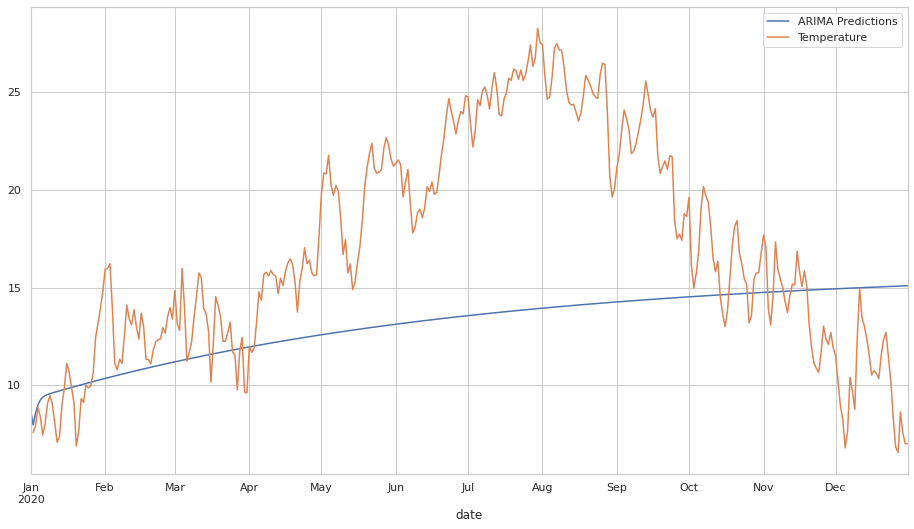

In [33]:
start='2020-01-01'
end='2020-12-31'
pred=result.predict(start,end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Temperature'].plot(legend=True)

### 2.2. Forecaster Autoregressor

In [62]:
infer_ = pd.infer_freq(train.index)
train.index.freq = infer_
infer_ = pd.infer_freq(test.index)
test.index.freq = infer_

In [63]:
train.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
               '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', name='date', length=2192, freq='D')

In [64]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 30
             )

forecaster.fit(y=train['Temperature'])
forecaster


ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-03-01 22:43:09 
Last fit date: 2022-03-01 22:43:10 
Skforecast version: 0.4.2 

In [81]:
fin_train= '2018-12-31'

In [214]:
fin_validacion = '2019-12-31'

In [215]:
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = temperatura.loc[:fin_validacion,'Temperature'],
                            initial_train_size = len(temperatura.loc[:fin_train]),
                            steps      = 1, #para predecir el precio del siguiente dia
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1826
Number of observations used for backtesting: 365
    Number of folds: 365
    Number of steps per fold: 1

Data partition in fold: 0
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-01 00:00:00 -- 2019-01-01 00:00:00
Data partition in fold: 1
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-02 00:00:00 -- 2019-01-02 00:00:00
Data partition in fold: 2
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-03 00:00:00 -- 2019-01-03 00:00:00
Data partition in fold: 3
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-04 00:00:00 -- 2019-01-04 00:00:00
Data partition in fold: 4
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-05 00:00:00 -- 2019-01-05 00:00:00
Data partition in fold: 5
 

Data partition in fold: 254
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-09-12 00:00:00 -- 2019-09-12 00:00:00
Data partition in fold: 255
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-09-13 00:00:00 -- 2019-09-13 00:00:00
Data partition in fold: 256
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-09-14 00:00:00 -- 2019-09-14 00:00:00
Data partition in fold: 257
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-09-15 00:00:00 -- 2019-09-15 00:00:00
Data partition in fold: 258
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-09-16 00:00:00 -- 2019-09-16 00:00:00
Data partition in fold: 259
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-09-17 00:00:00 -- 2019-09-17 00:00:00
Data partition in fold: 260
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-09-18 00:00:00 -

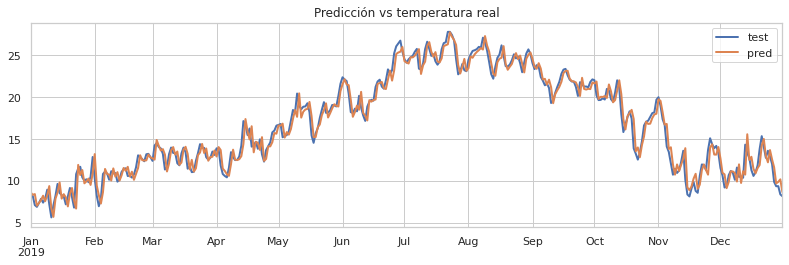

In [216]:
fig, ax = plt.subplots(figsize=(12, 3.5))
temperatura.loc[predicciones.index[-365:], 'Temperature'].plot(ax=ax, linewidth=2, label='test')
predicciones[-365:].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs temperatura real')
ax.legend();

In [217]:
print(f'Error backtest: {metrica}')

Error backtest: [0.77457602]


## 3. Distribución de probabilidad del consumo (Febrero 2020)

Supongamos una comercializadora de electricidad que agrega un 10% de toda la demanda de España. Se asume que el consumo agregado de sus clientes en todo momento es proporcional al consumo total del país.

In [91]:
best_model = pickle.load(open('../models/bestdemandmodel', 'rb'))

In [133]:
temp_dem = pd.read_csv('../data/demandalimpio.csv')
temp_dem.set_index('date',inplace=True)

In [93]:
exog=temp_dem[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30']]
exog.dropna(inplace=True)

/tmp/ipykernel_323/2362069212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog.dropna(inplace=True)


In [ ]:
metrica, predicciones = backtesting_forecaster(
                            forecaster = best_model,
                            y          = temp_dem.value,
                            initial_train_size = len(temp_dem[:fin_train]),
                            steps      = 1,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                        )


fig, ax = plt.subplots(figsize=(12, 3.5))
temp_dem.loc[predicciones.index[:365], 'value'].plot(linewidth=2, label='test', ax=ax)
predicciones[:365].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();


In [100]:
predicciones = best_model.predict(steps=365)

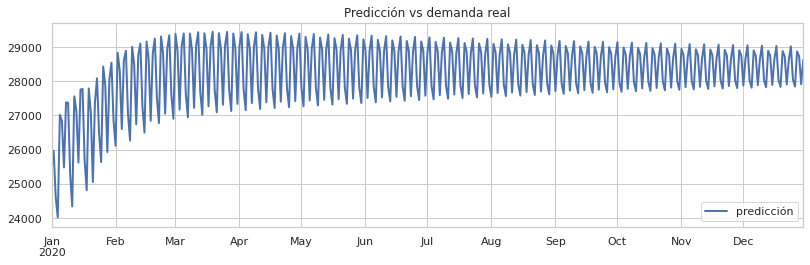

In [102]:
fig, ax = plt.subplots(figsize=(12, 3.5))
# temp_dem.loc[predicciones.index[:365], 'value'].plot(linewidth=2, label='test', ax=ax)
predicciones[:365].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

Me encuentro con un problema de predicción del modelo. Para mayor efectividad del análisis voy a utilizar directamente las predicciones obtenidas en el primer problema para la demanda de 2020.

In [103]:
predicciones = pd.read_csv('../data/pred_dem_2020.csv')

In [106]:
predicciones.rename(columns={'Unnamed: 0': 'date', 'pred':'demanda'},inplace=True)

In [107]:
predicciones.set_index('date',inplace=True)

<AxesSubplot:xlabel='date'>

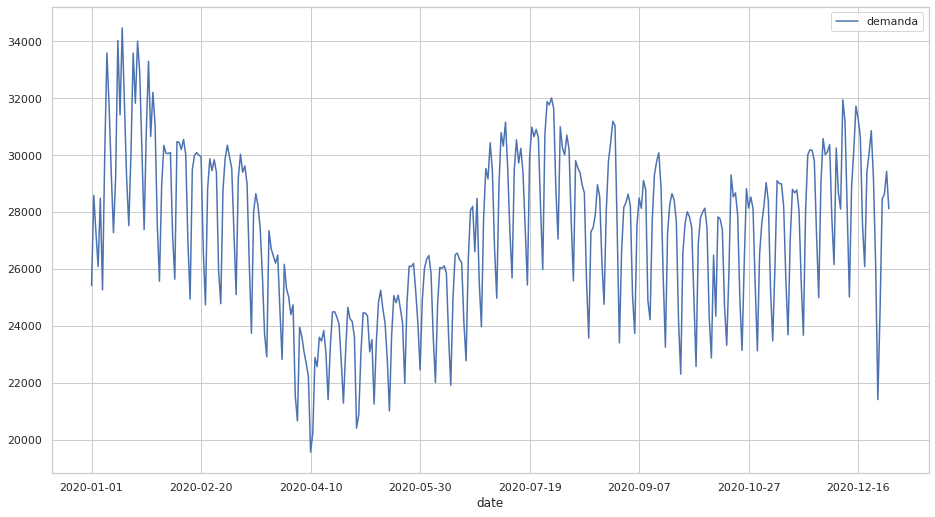

In [108]:
predicciones.plot()

In [110]:
pred_febrero = predicciones.loc['2020-02-01':'2020-02-29']

In [ ]:
inicio_feb

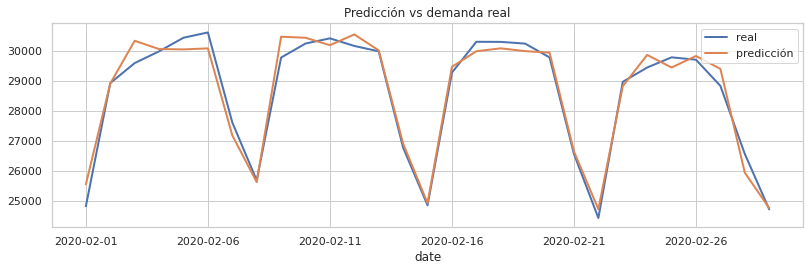

In [136]:
# pred_febrero.plot()
fig, ax = plt.subplots(figsize=(12, 3.5))
temp_dem.loc[pred_febrero.index, 'value'].plot(ax=ax, linewidth=2, label='real')
pred_febrero.demanda.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [139]:
error_mae = mean_absolute_error(
                y_true = temp_dem.loc[pred_febrero.index, 'value'],
                y_pred = pred_febrero.demanda
            )
print(f"Error de test (mse): {error_mae}")

Error de test (mse): 291.3186994723649


In [141]:
demanda_media_febrero = pred_febrero.demanda.mean()
demanda_media_febrero

28636.55059287844

En base a estos valores, vamos a realizar una distribución normal del consumo de los clientes de la comercializadora, usando un 10% de la demanda media de febrero y calculando la desviación estandar a partir del error medio absoluto

In [149]:
demanda_media_clientes = 0.1*demanda_media_febrero
stdev = np.sqrt(np.pi/2)*error_mae

In [146]:
stdev

365.1138445130805

matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


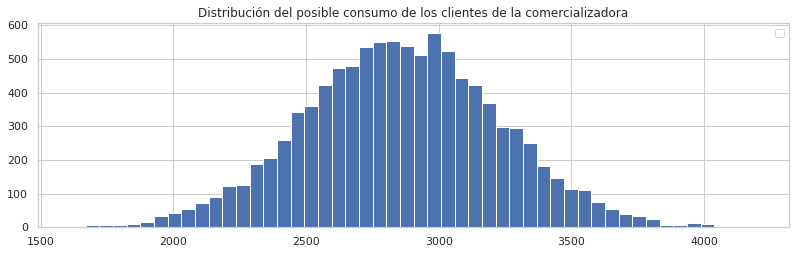

In [156]:
 
values = np.random.normal(demanda_media_clientes, stdev, 10000)  
fig, ax = plt.subplots(figsize=(12, 3.5))
plt.hist(values, 50)  
ax.set_title('Distribución del posible consumo de los clientes de la comercializadora')
ax.legend()

## 4. Valoración de prima

Supongamos un derivado cuyo subyacente es el volumen de electricidad entregado por la comercializadora en un mes, V (MWh). El derivado fija un volumen mensual mínimo K (MWh) y paga 1€/MWh por cada MWh no entregado por debajo de K. El pago del derivado para el mes en cuestión (en €) es P_K(V) = 1€/MWh * max(0, K-V).

Para la valoración de la prima a pagar consideraremos que V viene dado por el 10% de la demanda agregada (cuya distribución de probabilidad se ha calculado en el apartado anterior). Supondremos un K fijo menor que la media mensual de electricidad demandada, para obtener beneficio y calcularemos la prima trayendo a presente todos los posibles pagos del derivado para todos los meses de 2022.

In [158]:
demanda_2020 = temp_dem[['value']]

In [160]:
# demanda_2020['mes'] = pd.to_datetime(df.fecha).dt.day
demanda_2020["fecha"] = demanda_2020.index.astype(str)
demanda_2020['mes'] = pd.to_datetime(demanda_2020.fecha).dt.month

/tmp/ipykernel_323/2632087223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_2020["fecha"] = demanda_2020.index.astype(str)
/tmp/ipykernel_323/2632087223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_2020['mes'] = pd.to_datetime(demanda_2020.fecha).dt.month


In [165]:
demanda_mensual = demanda_2020.groupby('mes').mean()
media_anual = demanda_mensual.value.mean()

In [168]:
demanda_mensual_comercializadora = demanda_mensual*0.1
media_anual_comercializadora = media_anual*0.1

In [169]:
demanda_mensual_comercializadora

,value
mes,
1,3060.093488
2,3020.590600
3,2824.041041
4,2605.467437
5,2633.025128
6,2799.119411
7,3005.563399
8,2852.682200
9,2798.139276


In [170]:
media_anual_comercializadora

2831.168004029125

In [171]:
tasa_descuento = 0.03    #3% anual para mantener un perfil conservador

In [189]:
def prima(df, k, tasa):
    suma= 0
    for i in df.index:
        pago = max(0,k-df.value[i])
        suma += (pago)/((1+tasa)**(i/12)) #asumiendo que cada mes es un doceavo del periodo
    return suma

In [205]:
prima(demanda_mensual_comercializadora,2605.468,tasa_descuento)

0.0005573123843321457

In [218]:
primas = []
for i in range(0, 3000):

    suma = prima(demanda_mensual_comercializadora,i,tasa_descuento)
    primas.append(suma)

In [219]:
calculo_primas = pd.DataFrame(primas)

<AxesSubplot:>

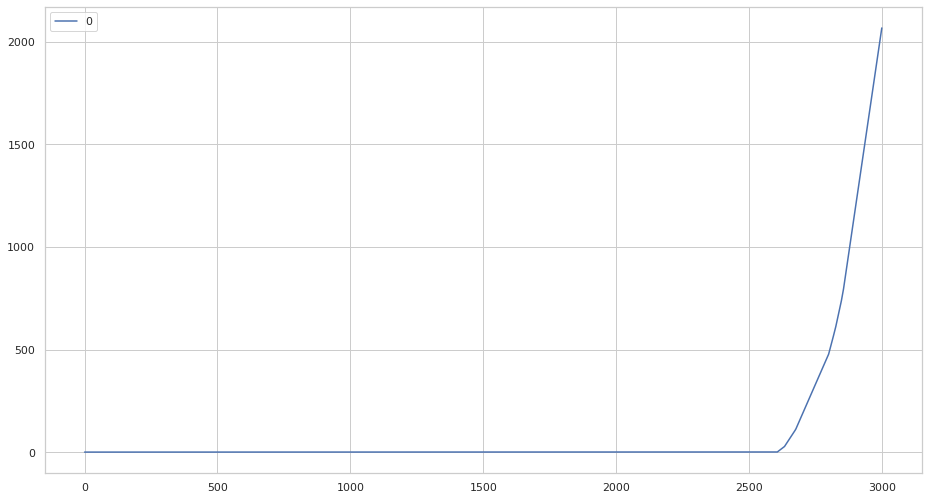

In [220]:
calculo_primas.plot()

In [181]:
k=2800
suma= 0
for i in demanda_mensual_comercializadora.index:
    pago = max(0,k-demanda_mensual_comercializadora.value[i])
    print(pago)
    suma += (pago)/((1+tasa_descuento)**(i/12))
    print(suma)

0
0.0
0
0.0
0
0.0
194.53256283068777
192.6252580170239
166.97487199180705
357.5562517100418
0.880588624338543
358.423921463621
0
358.423921463621
0
358.423921463621
1.8607242063490048
360.2438489697822
124.94004595494107
482.1439243275229
0
482.1439243275229
0
482.1439243275229
